In [1]:
#pip install numpy pandas matplotlib seaborn opencv-python tensorflow opendatasets scikit-learn

In [2]:
# 1. Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Import libraries for handling dataset and training
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 3. Import TensorFlow and Keras related libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall


# 4. Import concurrent execution libraries
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

2024-11-26 13:03:36.834352: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 13:03:36.837833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 13:03:36.848378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732606416.866273   14297 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732606416.871405   14297 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 13:03:36.890283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# Download dataset
#od.download("https://www.kaggle.com/datasets/anaselmasry/covid19normalpneumonia-ct-images/data")

In [4]:
# Set paths and constants
base_path = './covid19normalpneumonia-ct-images'
classes = ['COVID2_CT', 'Normal_CT', 'pneumonia_CT']
num_augmentations_per_image = 5
img_size = (256, 256)
epochs=50
augmented_path = 'AugmentedData'  # Path to save augmented images

In [5]:
def augment_image(img_path, augmented_class_path, img_file, i, datagen):
    """Augment a single image and save the result."""
    img_array = img_to_array(load_img(img_path)).reshape((1,) + img_to_array(load_img(img_path)).shape)
    aug_iter = datagen.flow(img_array, batch_size=1)
    
    augmented_img = next(aug_iter)[0].astype(np.uint8)
    save_path = os.path.join(augmented_class_path, f"augmented_{img_file.split('.')[0]}_{i}.jpg")
    cv2.imwrite(save_path, augmented_img)

def augment_images(class_name):
    """Augment images for a specified class."""
    class_path = os.path.join(base_path, class_name)
    augmented_class_path = os.path.join(augmented_path, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)

    print(f"{class_name}: images started augmentation")
    
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_files = os.listdir(class_path)
    
    with ThreadPoolExecutor() as executor:
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            for i in range(num_augmentations_per_image):
                executor.submit(augment_image, img_path, augmented_class_path, img_file, i, datagen)

    print(f"{class_name}: Augmentation completed.")

# Perform augmentation for each class
for class_name in classes:
    augment_images(class_name)

print("Augmentation completed.")


COVID2_CT: images started augmentation
COVID2_CT: Augmentation completed.
Normal_CT: images started augmentation
Normal_CT: Augmentation completed.
pneumonia_CT: images started augmentation
pneumonia_CT: Augmentation completed.
Augmentation completed.


In [6]:
mask_base_path = './masks'

os.makedirs(mask_base_path, exist_ok=True)
for class_name in classes:
    os.makedirs(os.path.join(mask_base_path, class_name), exist_ok=True)

def generate_mask(image_path):
    """Generate a mask for a given image using thresholding."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def process_image_and_save_mask(img_file, img_dir, mask_dir):
    """Process an image and save its corresponding mask."""
    img_path = os.path.join(img_dir, img_file)
    mask = generate_mask(img_path)
    if mask is not None:
        mask_filename = f"mask_{img_file}"
        mask_path = os.path.join(mask_dir, mask_filename)
        cv2.imwrite(mask_path, mask)

def create_masks_for_class(class_name, augmented=False):
    """Create masks for images in a specific class."""
    img_dir = os.path.join(augmented_path if augmented else base_path, class_name)
    mask_dir = os.path.join(mask_base_path, class_name)
    img_files = os.listdir(img_dir)

    with ProcessPoolExecutor() as executor:
        for img_file in img_files:
            executor.submit(process_image_and_save_mask, img_file, img_dir, mask_dir)

# Create masks for both original and augmented images
for class_name in classes:
    create_masks_for_class(class_name)  # Original images
    create_masks_for_class(class_name, augmented=True)  # Augmented images
print("Masks created.")


Masks created.


Displaying images and masks for: COVID2_CT
Displaying images and masks for: Normal_CT
Displaying images and masks for: pneumonia_CT


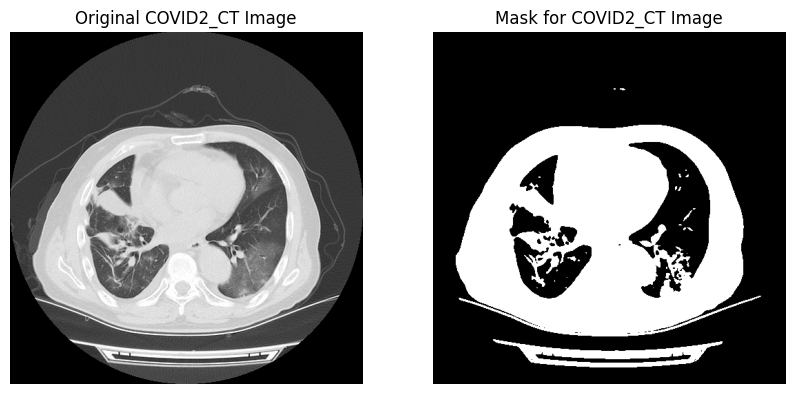

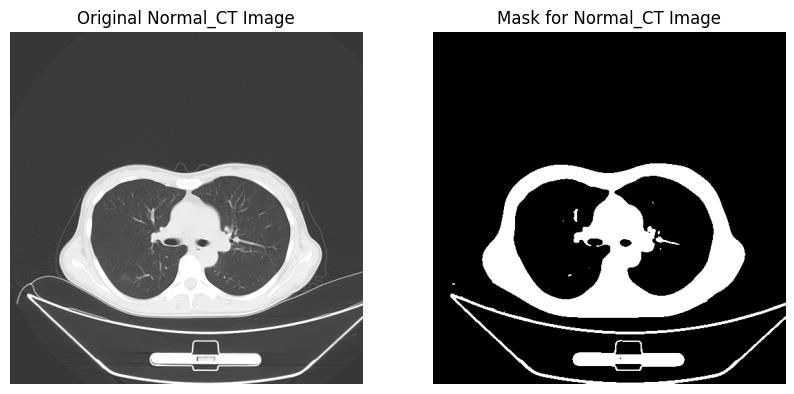

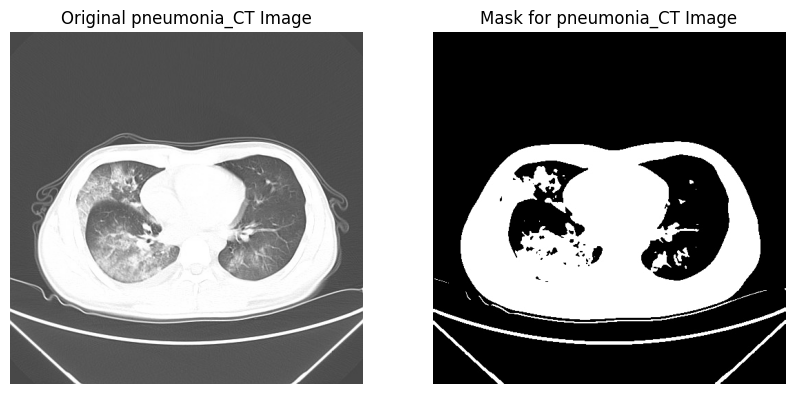

In [7]:
def display_images_with_mask(image_class):
    """Display an original image and its mask for a specified class."""
    img_dir = os.path.join(base_path, image_class)
    mask_dir = os.path.join(mask_base_path, image_class)
    original_image_file = os.listdir(img_dir)[0]

    img_path = os.path.join(img_dir, original_image_file)
    mask_path = os.path.join(mask_dir, f'mask_{original_image_file}')

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Original {image_class} Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask for {image_class} Image')
    plt.axis('off')
 
# Display images for each class
for class_name in classes:
    print(f"Displaying images and masks for: {class_name}")
    display_images_with_mask(class_name)



In [8]:
# U-Net Model Definition
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
model = unet_model(input_size=(256, 256, 3))
model.summary()


W0000 00:00:1732606421.369855   14297 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Load Images and Masks
image_base_path = './covid19normalpneumonia-ct-images'
mask_base_path = './masks'
img_size = (256, 256)  

def load_images_and_masks(classes, num_images=None):
    images = []
    masks = []

    for class_name in classes:
        img_dir = os.path.join(image_base_path, class_name)
        mask_dir = os.path.join(mask_base_path, class_name)

        img_files = os.listdir(img_dir)
        if num_images:
            img_files = img_files[:num_images] 

        for img_file in img_files:
            img_path = os.path.join(img_dir, img_file)
            mask_path = os.path.join(mask_dir, f'mask_{img_file}')

            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize image

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize mask to 0-1 range

            images.append(img)
            masks.append(np.expand_dims(mask, axis=-1))  # Add a channel dimension to the mask

    return np.array(images), np.array(masks)

classes = ['COVID2_CT', 'Normal_CT', 'pneumonia_CT']
images, masks = load_images_and_masks(classes)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', MeanIoU(num_classes=2)])  

checkpoint = ModelCheckpoint('unet_lung_segmentation.keras', 
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=16,
                    callbacks=[checkpoint, early_stop])

Epoch 1/50


/home/ragu/.venvs/phase1/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 11s/step - accuracy: 0.5726 - loss: 0.6943 - mean_io_u: 0.3625 - val_accuracy: 0.2980 - val_loss: 0.6904 - val_mean_io_u: 0.3564
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 11s/step - accuracy: 0.2976 - loss: 0.6906 - mean_io_u: 0.3607 - val_accuracy: 0.2893 - val_loss: 0.6864 - val_mean_io_u: 0.3564
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 12s/step - accuracy: 0.2861 - loss: 0.6877 - mean_io_u: 0.3628 - val_accuracy: 0.2878 - val_loss: 0.6832 - val_mean_io_u: 0.3564
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 11s/step - accuracy: 0.2766 - loss: 0.6858 - mean_io_u: 0.3650 - val_accuracy: 0.2878 - val_loss: 0.6805 - val_mean_io_u: 0.3564
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 11s/step - accuracy: 0.2834 - loss: 0.6833 - mean_io_u: 0.3638 - val_accuracy: 0.2879 - val_loss: 0.6774 - val_mean_io_u: 0.3564
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 11s/step - accuracy: 0.2904 - loss: 0.6802 - mean_io_u: 0.3619 - val_accuracy: 0.2888 - val_loss: 0.6737 - val_mean_io_u: 0.35

Training completed.


/tmp/ipykernel_14297/2919109556.py:21: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


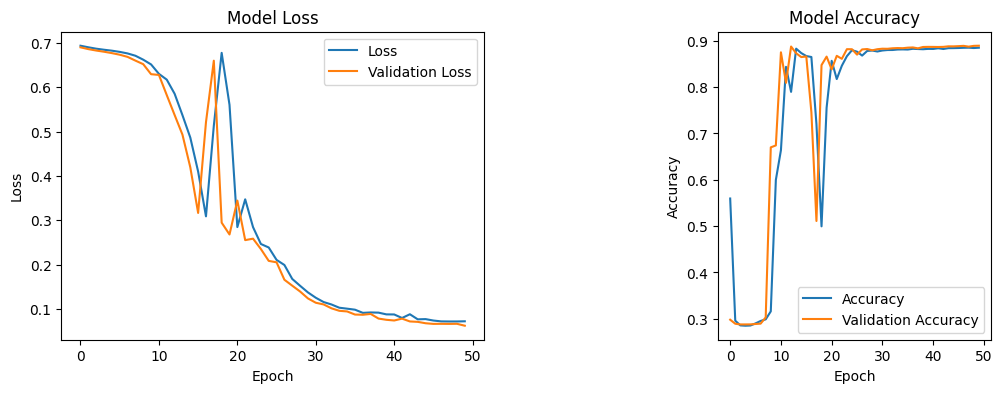

In [13]:
def plot_training_history(history):
    """Plot training and validation loss and IoU metrics."""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()


plot_training_history(history)

print("Training completed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


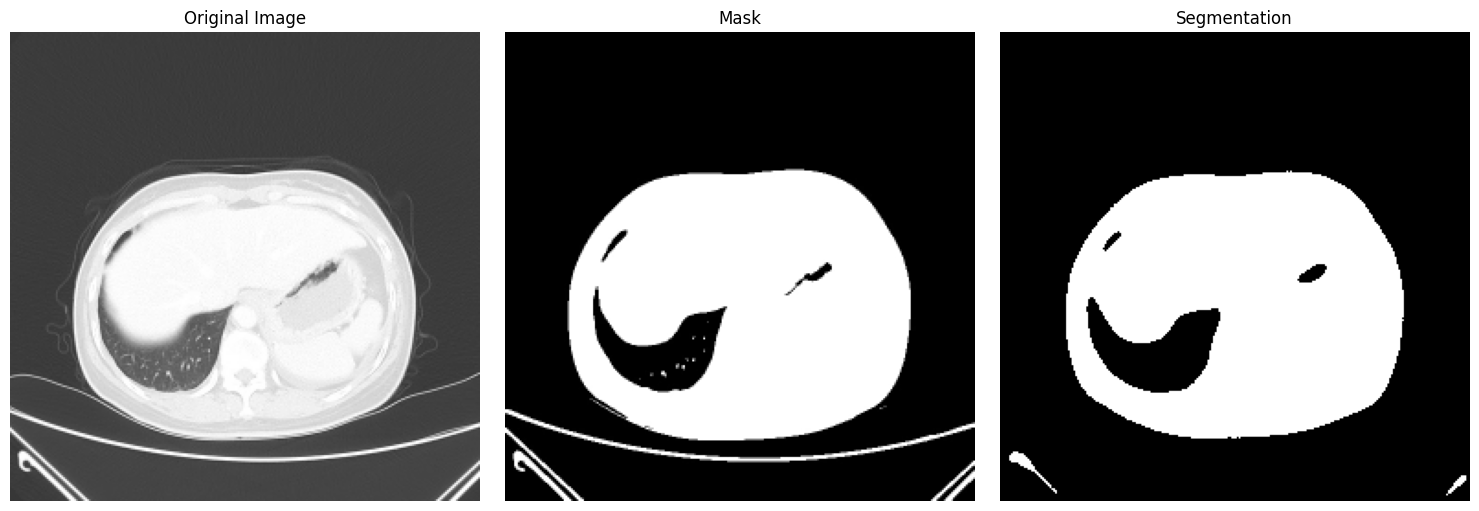

In [14]:
def display_sample_prediction(X_val, y_val, model, index=0):
    sample_image = X_val[index]
    true_mask = y_val[index]
    
    predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
    
    predicted_mask_binary = (predicted_mask > 0.85).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[:, :, 0], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
    plt.title('Segmentation')
    plt.axis('off')

    plt.tight_layout()

display_sample_prediction(X_val, y_val, model, index=0)

In [15]:
os.makedirs('Models', exist_ok=True)
model.save('Models/unet_model.h5')

In [16]:

def generate_segmented_mask(img_path, output_dir, threshold=0.85):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  
    
    predicted_mask = model.predict(img_array)[0]
    
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)
    
    predicted_mask_resized = cv2.resize(predicted_mask_binary, (img.width, img.height))
    
    mask_filename = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(mask_filename, predicted_mask_resized * 255) 

input_dirs = {
    'COVID2_CT': 'covid19normalpneumonia-ct-images/COVID2_CT',
    'Normal_CT': 'covid19normalpneumonia-ct-images/Normal_CT',
    'pneumonia_CT': 'covid19normalpneumonia-ct-images/pneumonia_CT'
}

output_dir = 'segmented_masks'  
os.makedirs(output_dir, exist_ok=True)

for class_name, input_dir in input_dirs.items():
    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)
    
    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        generate_segmented_mask(img_path, class_output_dir)

print("Segmentation masks saved successfully!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
def load_data_from_directory(directory, img_size=(299, 299)):
    images = []
    labels = []
    label_map = {'COVID2_CT': 0, 'Normal_CT': 1, 'pneumonia_CT': 2}
    
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = image.load_img(img_path, target_size=img_size)
                img_array = image.img_to_array(img)
                img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
                images.append(img_array)
                labels.append(label_map[label])
                
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

X, y = load_data_from_directory('segmented_masks')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (24, 299, 299, 3)
Testing data shape: (6, 299, 299, 3)
Training labels shape: (24,)
Testing labels shape: (6,)


In [19]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def InceptionV3_BaseModel():
    base_model = InceptionV3(weights='imagenet', include_top=True)  
    x = base_model.output
    predictions = Dense(3, activation='softmax')(x)  
    model = Model(inputs=base_model.input, outputs=predictions)
    base_model.trainable = False
    model.compile(optimizer=Adam(), 
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])

    return model

model = InceptionV3_BaseModel()

#model.summary()


In [20]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2500 - loss: 1.0972 - val_accuracy: 0.3333 - val_loss: 1.1161
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.0969 - val_accuracy: 0.3333 - val_loss: 1.1161
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.0966 - val_accuracy: 0.1667 - val_loss: 1.1161
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 1.0963 - val_accuracy: 0.1667 - val_loss: 1.1162
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - loss: 1.0959 - val_accuracy: 0.1667 - val_loss: 1.1162
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 1.0956 - val_accuracy: 0.1667 - val_loss: 1.1162
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 1.0953 - val_accuracy: 0.1667 - val_loss: 1.1163
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 1.0950 - val_accuracy: 0.1667 - val_loss: 1.1163
Epoch 9/50
1/1 ━

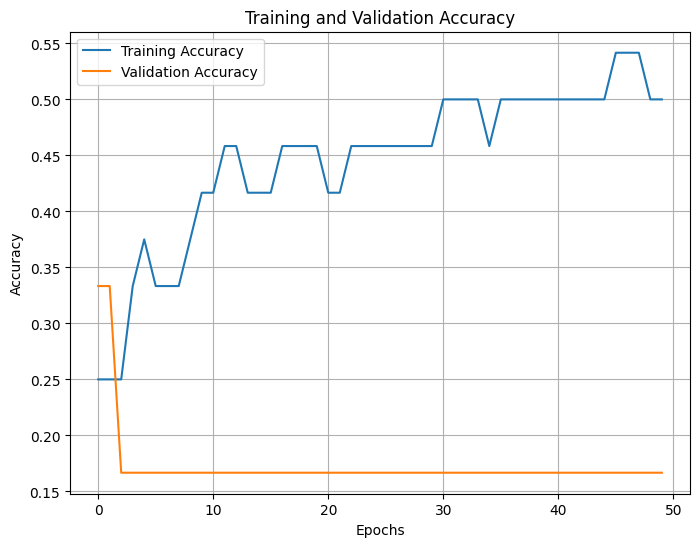

In [21]:
def plot_accuracy(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
   
plot_accuracy(history)

In [22]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [23]:
report = classification_report(
    y_test, y_pred_class, labels=[0, 1, 2], target_names=['COVID', 'Normal', 'Pneumonia'], output_dict=True
)

accuracy = accuracy_score(y_test, y_pred_class)

print("Accuracy:", accuracy)

report_df = pd.DataFrame(report).transpose()

print(report_df)

Accuracy: 0.16666666666666666
              precision    recall  f1-score   support
COVID          0.250000  0.500000  0.333333  2.000000
Normal         0.000000  0.000000  0.000000  2.000000
Pneumonia      0.000000  0.000000  0.000000  2.000000
accuracy       0.166667  0.166667  0.166667  0.166667
macro avg      0.083333  0.166667  0.111111  6.000000
weighted avg   0.083333  0.166667  0.111111  6.000000


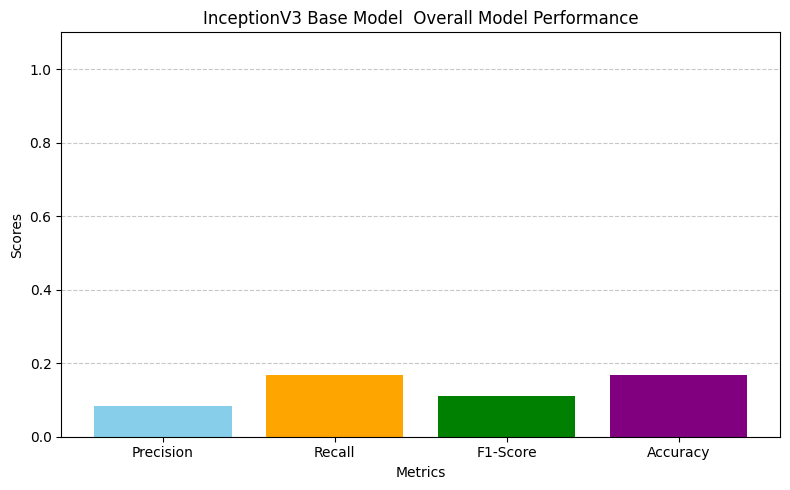

In [24]:
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [
    report['weighted avg']['precision'],  
    report['weighted avg']['recall'],     
    report['weighted avg']['f1-score'],   
    accuracy                             
]
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'purple'])
plt.title("InceptionV3 Base Model")
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('InceptionV3 Base Model  Overall Model Performance')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[2 0 2 0 1 1]
[0 1 0 0 0 2]


<Figure size 800x600 with 0 Axes>

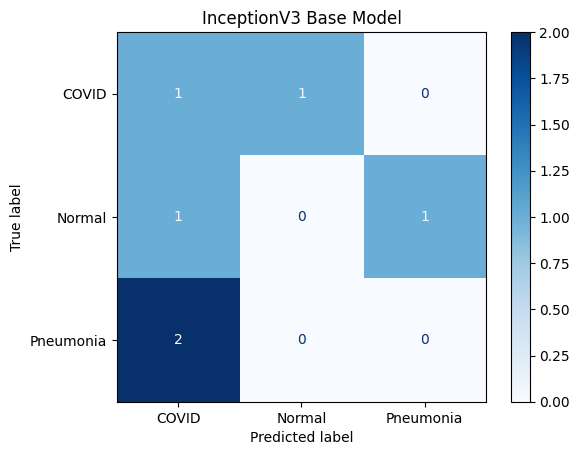

In [25]:
print(y_test)
print(y_pred_class)
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID', 'Normal', 'Pneumonia'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("InceptionV3 Base Model")
plt.show()

In [26]:
os.makedirs('Models', exist_ok=True)
model.save('Models/InceptionV3_BasedModel.h5')

In [27]:
def InceptionV3_improved():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False  # Freeze the base model
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(3, activation='softmax')  # 3 output classes: COVID, Normal, Pneumonia
    ])
    
    model.compile(optimizer=Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = InceptionV3_improved()
#model.summary()

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2917 - loss: 1.4394 - val_accuracy: 0.0000e+00 - val_loss: 1.3472
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.4421 - val_accuracy: 0.0000e+00 - val_loss: 1.3830
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3333 - loss: 1.2577 - val_accuracy: 0.0000e+00 - val_loss: 1.3587
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4583 - loss: 1.1553 - val_accuracy: 0.1667 - val_loss: 1.3118
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4167 - loss: 1.1438 - val_accuracy: 0.1667 - val_loss: 1.2646
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.3204 - val_accuracy: 0.1667 - val_loss: 1.2158
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - loss: 1.2131 - val_accuracy: 0.1667 - val_loss: 1.1913
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.9276 - val_accuracy: 0.5000 - val_loss: 1.1707
Epoc

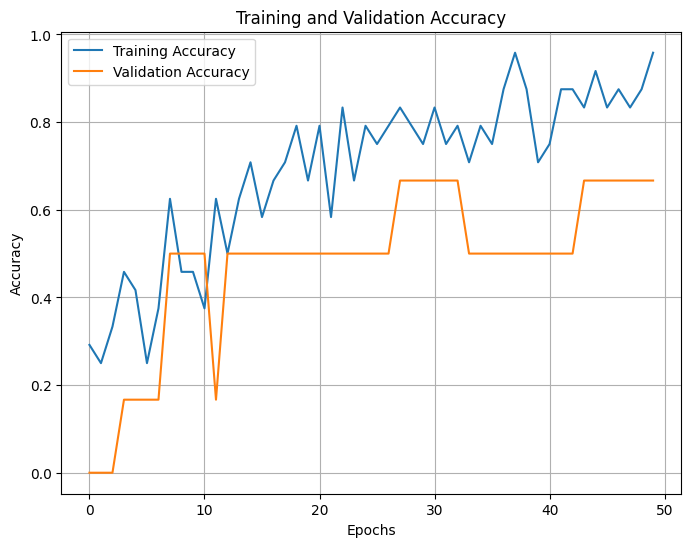

In [29]:
def plot_accuracy(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
  
    plt.figure(figsize=(8, 6))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    os.makedirs('plots', exist_ok=True)
    plt.savefig("plots/Accuracy_InceptionV3.png")

plot_accuracy(history)

In [30]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [31]:
report = classification_report(
    y_test, y_pred_class, labels=[0, 1, 2], target_names=['COVID', 'Normal', 'Pneumonia'], output_dict=True
)

accuracy = accuracy_score(y_test, y_pred_class)

precision = [report[label]['precision'] for label in ['COVID', 'Normal', 'Pneumonia']]

print("Accuracy:", accuracy)

report_df = pd.DataFrame(report).transpose()

print(report_df)

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support
COVID          0.500000  0.500000  0.500000  2.000000
Normal         1.000000  1.000000  1.000000  2.000000
Pneumonia      0.500000  0.500000  0.500000  2.000000
accuracy       0.666667  0.666667  0.666667  0.666667
macro avg      0.666667  0.666667  0.666667  6.000000
weighted avg   0.666667  0.666667  0.666667  6.000000


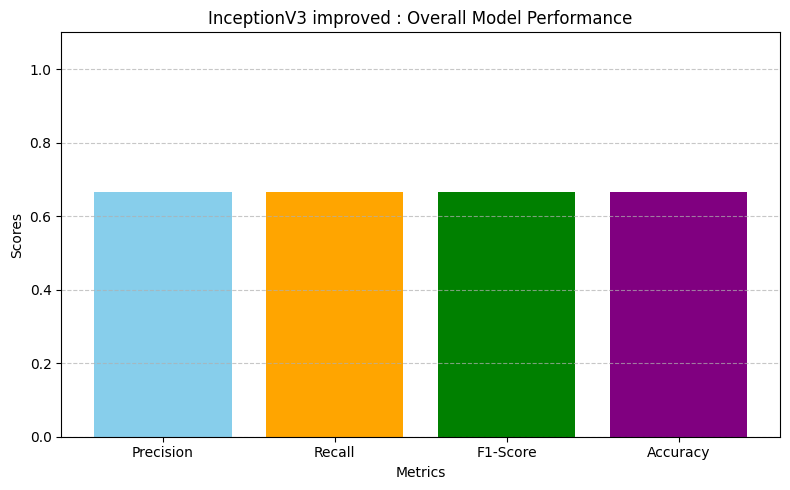

In [32]:
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [
    report['weighted avg']['precision'],  
    report['weighted avg']['recall'],    
    report['weighted avg']['f1-score'],   
    accuracy                            
]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green', 'purple'])
plt.title("InceptionV3 improved")
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('InceptionV3 improved : Overall Model Performance')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

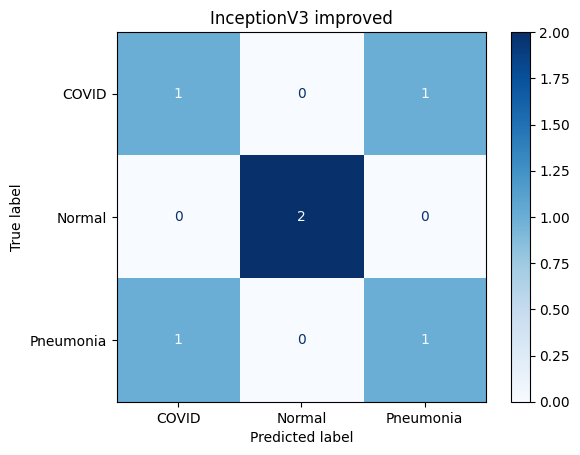

In [33]:
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID', 'Normal', 'Pneumonia'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("InceptionV3 improved")
plt.show()

In [34]:
os.makedirs('Models', exist_ok=True)
model.save('Models/InceptionV3_improved.h5')